In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

2023-08-24 20:22:19.535591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
from tensorflow.keras.optimizers import Adam

# Data preparation

In [3]:
data_path = "/home/wolinammentorp/data/smart_pixels_13/unflipped/"

In [4]:
pq1 = pd.read_parquet(data_path + "recon3D_d17501.parquet")

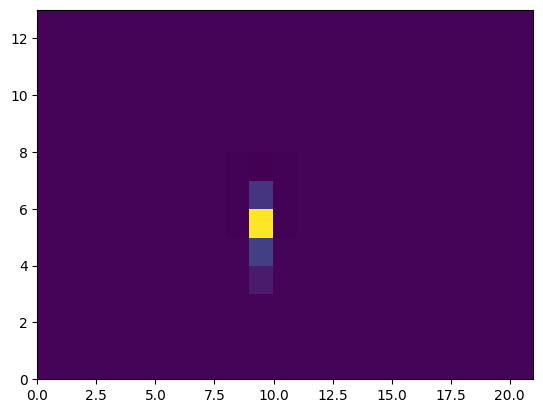

In [5]:
arr = np.array(pq1.iloc[0])
arr = np.reshape(arr, (20, 13, 21))
plt.pcolor(np.sum(arr, axis=0))

In [6]:
pq1_truth = pd.read_parquet(data_path + "labels_d17501.parquet")

In [7]:
pq1_truth

,x-entry,y-entry,z-entry,n_x,n_y,n_z,number_eh_pairs,y-local,pt,cotAlpha,cotBeta,y-midplane,x-midplane
0,-48.731285,2.872706,100.0,-0.239328,-0.141072,-1.238494,17510.0,-3.83818,-1.2465,0.193241,0.113906,-2.822598,-58.393342
1,-175.338928,25.938915,100.0,0.809492,-0.089265,-0.325481,17308.0,-6.57575,0.3375,-2.487064,0.274256,12.226133,-50.985740
2,177.558731,9.934172,100.0,-0.312144,-0.010484,-0.115023,43849.0,-7.47091,-0.1155,2.713753,0.091147,5.376823,41.871086
3,-418.620941,-10.610765,100.0,6.665171,-0.050723,-0.797890,66669.0,-2.55476,-0.7995,-8.353496,0.063571,-13.789336,-0.946136
4,-346.192657,0.553267,100.0,5.683409,-0.086886,-1.020810,51912.0,-2.04856,1.0245,-5.567548,0.085115,-3.702471,-67.815241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49967,48.692581,-14.837375,100.0,-0.620369,0.008676,-0.264358,29911.0,-0.95797,-0.2645,2.346700,-0.032819,-13.196418,-68.642434
49968,42.802876,4.589038,100.0,0.006787,-0.041867,-0.095746,15935.0,-7.43155,0.1045,-0.070885,0.437272,-17.274539,46.347149
49969,-301.871185,-10.112600,100.0,2.982382,0.074379,-0.573699,76986.0,4.80660,0.5785,-5.198514,-0.129648,-3.630194,-41.945510
49970,372.125732,-14.596362,100.0,-0.350652,0.024985,-0.050675,51510.0,4.44579,-0.0565,6.919625,-0.493044,10.055833,26.144479


In [8]:
def get_training(charge_file, truth_file):
    xs = []
    ys = []

    for idx, row in charge_file.iterrows():   
        truth = truth_file.iloc[idx]
        pt = np.array(truth["pt"])

        x = row
        y = pt

        xs.append(x)
        ys.append(y)
    
    return np.array(xs), np.array(ys)

        

In [9]:
prof, pt = get_training(pq1, pq1_truth)

In [10]:
prof.shape

(49972, 5460)

In [11]:
20 * 13 * 21

5460

In [12]:
def build_set(train_start, train_stop):
    n_files = train_stop - train_start

    train_files_charge = ["recon3D_d" + str(i) + ".parquet" for i in range(train_start, train_stop)]
    train_files_truth = ["labels_d" + str(i) + ".parquet" for i in range(train_start, train_stop)]

    data_files_train = [pd.read_parquet(data_path + f) for f in train_files_charge]
    truth_files_train = [pd.read_parquet(data_path + f) for f in train_files_truth]

    train_data = [get_training(data_files_train[i], truth_files_train[i]) for i in range(1, n_files)]

    X_train = np.concatenate([d[0] for d in train_data], axis=0)
    y_train = np.concatenate([d[1] for d in train_data], axis=0)
    y_train = np.reshape(y_train, (-1, 1))

    return X_train, y_train


In [13]:
train_start = 17501
train_stop = 17505

In [14]:
X_train, y_pt_train = build_set(17501, 17510)

In [15]:
X_train.shape

(399800, 5460)

In [16]:
y_pt_train.shape

(399800, 1)

In [17]:
#original is 652,160 samples

In [18]:
X_test, y_pt_test = build_set(17511, 17513)

In [19]:
X_test.shape

(49978, 5460)

In [20]:
y_pt_test.shape

(49978, 1)

In [21]:
#X_test_huge, y_pt_test_huge = build_set(17514, 17534)

In [22]:
def get_truth(momenta, threshold):
    return 1.0 * (momenta > threshold) + 2.0 * (momenta < -1 * threshold)

In [23]:
threshold = 0.2

In [24]:
y_train = get_truth(y_pt_train, threshold)

In [25]:
y_test = get_truth(y_pt_test, threshold)

In [26]:
#y_test_huge = get_truth(y_pt_test_huge, threshold)

(array([ 69875.,      0.,      0.,      0.,      0., 165122.,      0.,
             0.,      0., 164803.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

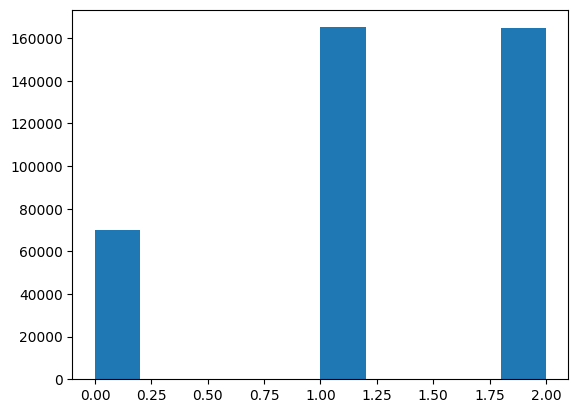

In [27]:
plt.hist(y_train)

In [28]:
#original is 3,597,877 test samples

# Training

In [29]:
# X_train = df1.values
# X_test = df3.values

# y_train = df2.values
# y_test = df4.values
# #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(399800, 5460) (49978, 5460) (399800, 1) (49978, 1)


In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [31]:
#X_test_huge = scaler.transform(X_test_huge.reshape(-1, X_test_huge.shape[-1])).reshape(X_test_huge.shape)

In [32]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(5460,)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 5460)              0         
                                                                 
 dense (Dense)               (None, 256)               1398016   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,431,299
Trainable params: 1,431,299
Non-trainable params: 0
_________________________________________________________________


In [33]:
es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=20,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size=128,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)



Epoch 1/200
2499/2499 [==============================] - 8s 2ms/step - loss: 1.0291 - sparse_categorical_accuracy: 0.4683 - val_loss: 0.9712 - val_sparse_categorical_accuracy: 0.4797
Epoch 2/200
2499/2499 [==============================] - 5s 2ms/step - loss: 0.9672 - sparse_categorical_accuracy: 0.4812 - val_loss: 0.9609 - val_sparse_categorical_accuracy: 0.4815
Epoch 3/200
2499/2499 [==============================] - 5s 2ms/step - loss: 0.9574 - sparse_categorical_accuracy: 0.4838 - val_loss: 0.9610 - val_sparse_categorical_accuracy: 0.4835
Epoch 4/200
2499/2499 [==============================] - 5s 2ms/step - loss: 0.9515 - sparse_categorical_accuracy: 0.4857 - val_loss: 0.9511 - val_sparse_categorical_accuracy: 0.4866
Epoch 5/200
2499/2499 [==============================] - 5s 2ms/step - loss: 0.9463 - sparse_categorical_accuracy: 0.4871 - val_loss: 0.9560 - val_sparse_categorical_accuracy: 0.4838
Epoch 6/200
2499/2499 [==============================] - 5s 2ms/step - loss: 0.9429 -

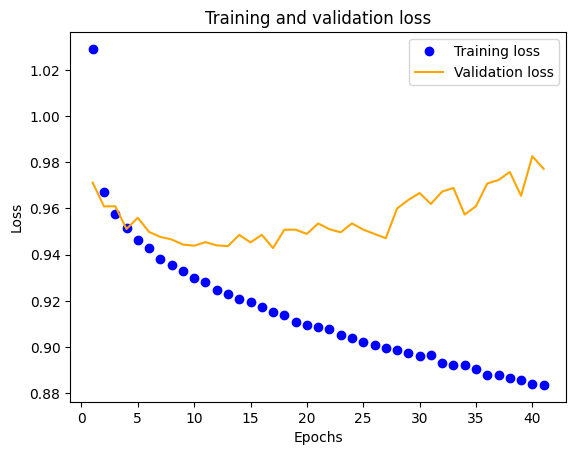

In [34]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

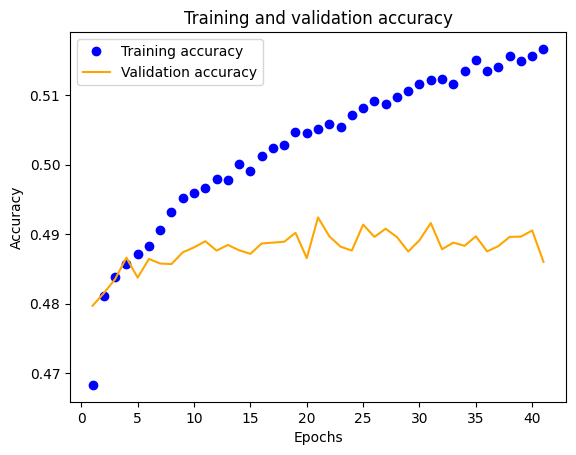

In [35]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig('accuracy.png')
plt.show()

In [36]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

1562/1562 [==============================] - 1s 730us/step


(array([ 2822.,     0.,     0.,     0.,     0., 41451.,     0.,     0.,
            0.,  5705.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

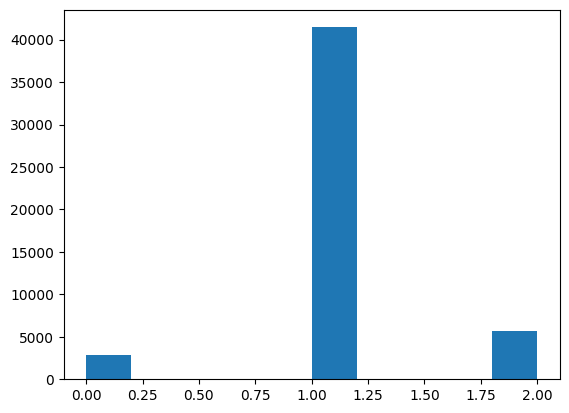

In [37]:
plt.hist(predictionsFiles)

In [38]:
#pd.DataFrame(predictionsFiles).to_csv("predictionsFiles.csv",header='predict', index=False)

In [39]:
#pd.DataFrame(y_test).to_csv("true.csv",header='true', index=False)

In [40]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.9521902799606323
Test accuracy: 0.49193644523620605


Confusion matrix:
[[ 2097  5667   884]
 [  313 18988  1320]
 [  412 16796  3501]]


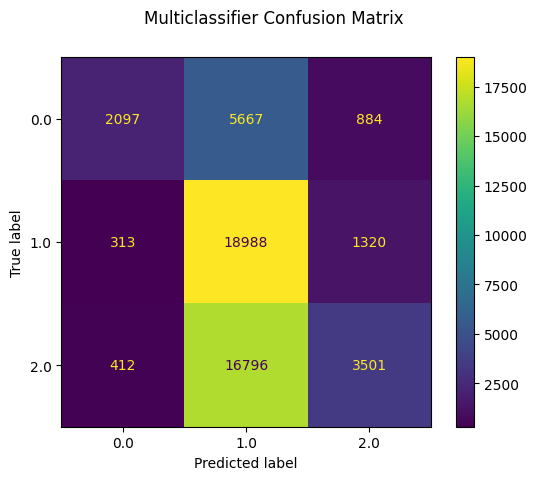

In [41]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('confusionMatrix.png')
plt.show()

In [42]:
#preds_huge = model.predict(X_test_huge) 
#predictionsFiles_huge =np.argmax(preds_huge, axis=1)

In [43]:
# disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test_huge, predictionsFiles_huge)
# disp.figure_.suptitle("Multiclassifier Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
# plt.savefig('confusionMatrix.png')
# plt.show()

# ROC curve

In [44]:
from sklearn.metrics import RocCurveDisplay

In [45]:
def ROC_OvR(preds, labels):
    classes = np.unique(labels)
    n_classes = len(classes)

    #go through each class to build a one-versus-rest ROC
    scores = []
    truth = []

    for c in range(1, n_classes):
        in_class = 1.0 *(labels == c)
        score = preds[:,c]

        scores.append(score)
        truth.append(in_class)

    scores = np.array(scores).ravel()
    truth = np.array(truth).ravel()

    return truth, scores


In [46]:
t, s = ROC_OvR(preds, y_test)

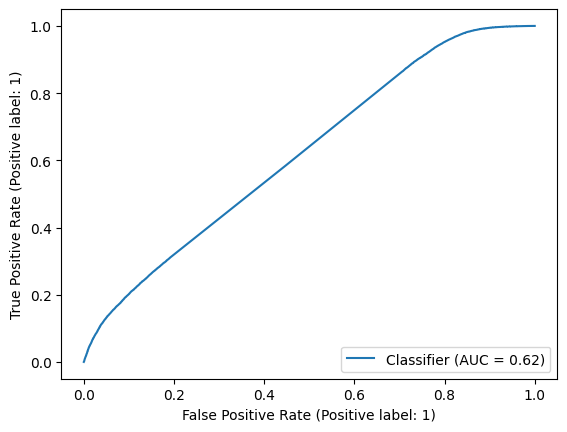

In [48]:
RocCurveDisplay.from_predictions(
    t,
    s,
    #plot_chance_level=True
)

In [49]:
from sklearn.metrics import roc_auc_score

In [52]:
t2, s2 = ROC_OvR(preds, y_test)

In [53]:
roc_auc_score(t2, s2)

0.6207705458962165

In [52]:
def test_roc_by_threshold(threshold):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(14,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer=Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
                metrics=[keras.metrics.SparseCategoricalAccuracy()])

    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=20,
                                   restore_best_weights=True)

    y_train = get_truth(y_pt_train, threshold)
    y_test_huge = get_truth(y_pt_test_huge, threshold)

    history = model.fit(X_train,
                        y_train,
                        callbacks=[es],
                        epochs=200, 
                        batch_size=1024,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=1)

    preds = model.predict(X_test_huge) 
    predictionsFiles = np.argmax(preds, axis=1)

    t, s = ROC_OvR(preds, y_test_huge)
    roc_auc = roc_auc_score(t, s)

    result = {"history" : history,
            "model" : model,
            "roc_auc" : roc_auc,}

    return result


In [53]:
res = test_roc_by_threshold(0.1)

Epoch 1/200
313/313 [==============================] - 3s 8ms/step - loss: 0.8125 - sparse_categorical_accuracy: 0.6088 - val_loss: 0.7564 - val_sparse_categorical_accuracy: 0.6789
Epoch 2/200
313/313 [==============================] - 2s 7ms/step - loss: 0.7306 - sparse_categorical_accuracy: 0.7008 - val_loss: 0.7142 - val_sparse_categorical_accuracy: 0.7134
Epoch 3/200
313/313 [==============================] - 2s 7ms/step - loss: 0.6987 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.6889 - val_sparse_categorical_accuracy: 0.7280
Epoch 4/200
313/313 [==============================] - 2s 7ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.7320 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.7351
Epoch 5/200
313/313 [==============================] - 2s 7ms/step - loss: 0.6559 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.6518 - val_sparse_categorical_accuracy: 0.7409
Epoch 6/200
313/313 [==============================] - 2s 7ms/step - loss: 0.6400 - sparse_cate

In [54]:
res

{'history': <keras.callbacks.History at 0x3546723d0>,
 'model': <keras.engine.sequential.Sequential at 0x3545b9430>,
 'roc_auc': 0.9144834817613869}

In [55]:
thresholds = np.linspace(0.2, 1.0, 9)

In [56]:
thresholds

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [57]:
res2 = [test_roc_by_threshold(t) for t in thresholds]

Epoch 1/200
313/313 [==============================] - 2s 7ms/step - loss: 0.9971 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.5714
Epoch 2/200
313/313 [==============================] - 2s 7ms/step - loss: 0.9481 - sparse_categorical_accuracy: 0.5920 - val_loss: 0.9329 - val_sparse_categorical_accuracy: 0.6079
Epoch 3/200
313/313 [==============================] - 2s 7ms/step - loss: 0.9200 - sparse_categorical_accuracy: 0.6097 - val_loss: 0.9078 - val_sparse_categorical_accuracy: 0.6198
Epoch 4/200
313/313 [==============================] - 2s 7ms/step - loss: 0.8963 - sparse_categorical_accuracy: 0.6225 - val_loss: 0.8869 - val_sparse_categorical_accuracy: 0.6244
Epoch 5/200
313/313 [==============================] - 2s 7ms/step - loss: 0.8769 - sparse_categorical_accuracy: 0.6320 - val_loss: 0.8689 - val_sparse_categorical_accuracy: 0.6292
Epoch 6/200
313/313 [==============================] - 2s 7ms/step - loss: 0.8602 - sparse_cate

In [60]:
roc_auc = np.array([r["roc_auc"] for r in res2])

In [61]:
roc_auc

array([0.86312258, 0.81111764, 0.77784263, 0.73018499, 0.62677491,
       0.57890733, 0.60992437, 0.57153878, 0.51216339])

Text(0, 0.5, 'ROC AUC')

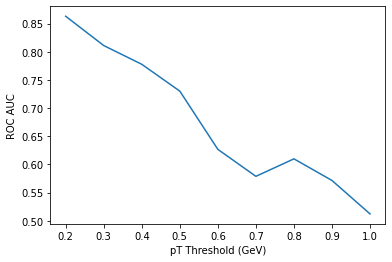

In [58]:
plt.plot(thresholds, [r["roc_auc"] for r in res2])
plt.xlabel("pT Threshold (GeV)")
plt.ylabel("ROC AUC")

In [110]:
#model.save('my_model.keras')

In [111]:
#model.save('my_model.h5')

In [22]:
#loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
#print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

112434/112434 - 87s - loss: 0.5151 - sparse_categorical_accuracy: 0.7878 - 87s/epoch - 778us/step
Restored model, accuracy: 78.78%
